In [1]:
"""
Benchmark Models
"""
import numpy as np
import pandas as pd

from datetime import datetime

import statsmodels.api as sm
from statsmodels import tsa
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt

from data_feed import direct_feed
from training_utils import directional_accuracy, mape, mse

plt.style.use("grayscale")
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (9, 3)

In [5]:
data_src = "../data/ready_to_use/complete_feature_target.csv"
rpna_dir = "../data/ready_to_use/rpna_r0_all.csv"
figure_dir = "../figures/tsa_figures/"

In [6]:
df_news = pd.read_csv(
    rpna_dir,
    index_col=0,
    header=0,
    parse_dates=["DATE"],
    date_parser=lambda d: datetime.strptime(d, "%Y-%m-%d")
)

In [7]:
# ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
X_train, X_test, y_train, y_test = direct_feed(
    src=data_src,
    test_start=pd.to_datetime("2020-01-01"),
    day=None,
    return_array=False
)
print(f"X_train @ {X_train.shape}")
print(f"y_train @ {y_train.shape}")
print(f"X_test @ {X_test.shape}")
print(f"y_test @ {y_test.shape}")
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

Dropped rows involving Nan: 2
X_train @ (4932, 416)
y_train @ (4932,)
X_test @ (0, 416)
y_test @ (0,)


In [8]:
df_all = pd.DataFrame(y_train.copy())

In [9]:
# Construct moving window predictors.
for w in [5, 25, 50, 100, 300]:
    df_all[f"MA_{w}"] = df_all["TARGET"].shift(1).rolling(window=w).mean()
df_all.fillna(value=0.0, inplace=True)
df_all["NAIVE"] = 0.0

In [17]:
df_all["MARTINGALE"] = df_all["TARGET"].shift(1)

In [18]:
df_all

,TARGET,MA_5,MA_25,MA_50,MA_100,MA_300,NAIVE,MARTINGALE
2000-02-07,-0.315405,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN
2000-02-08,-1.240051,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.315405
2000-02-09,2.325686,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-1.240051
2000-02-10,2.680573,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.325686
2000-02-11,0.067797,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.680573
...,...,...,...,...,...,...,...,...
2019-09-23,0.440220,-0.768089,-0.179106,-0.282382,-0.202657,-0.119498,0.0,-0.465077
2019-09-24,-2.536587,-1.625116,-0.184910,-0.275579,-0.205172,-0.118841,0.0,0.440220
2019-09-25,-1.478900,-0.876709,-0.320228,-0.318598,-0.226142,-0.110509,0.0,-2.536587
2019-09-26,-0.248624,-0.808069,-0.375114,-0.284439,-0.212198,-0.114538,0.0,-1.478900


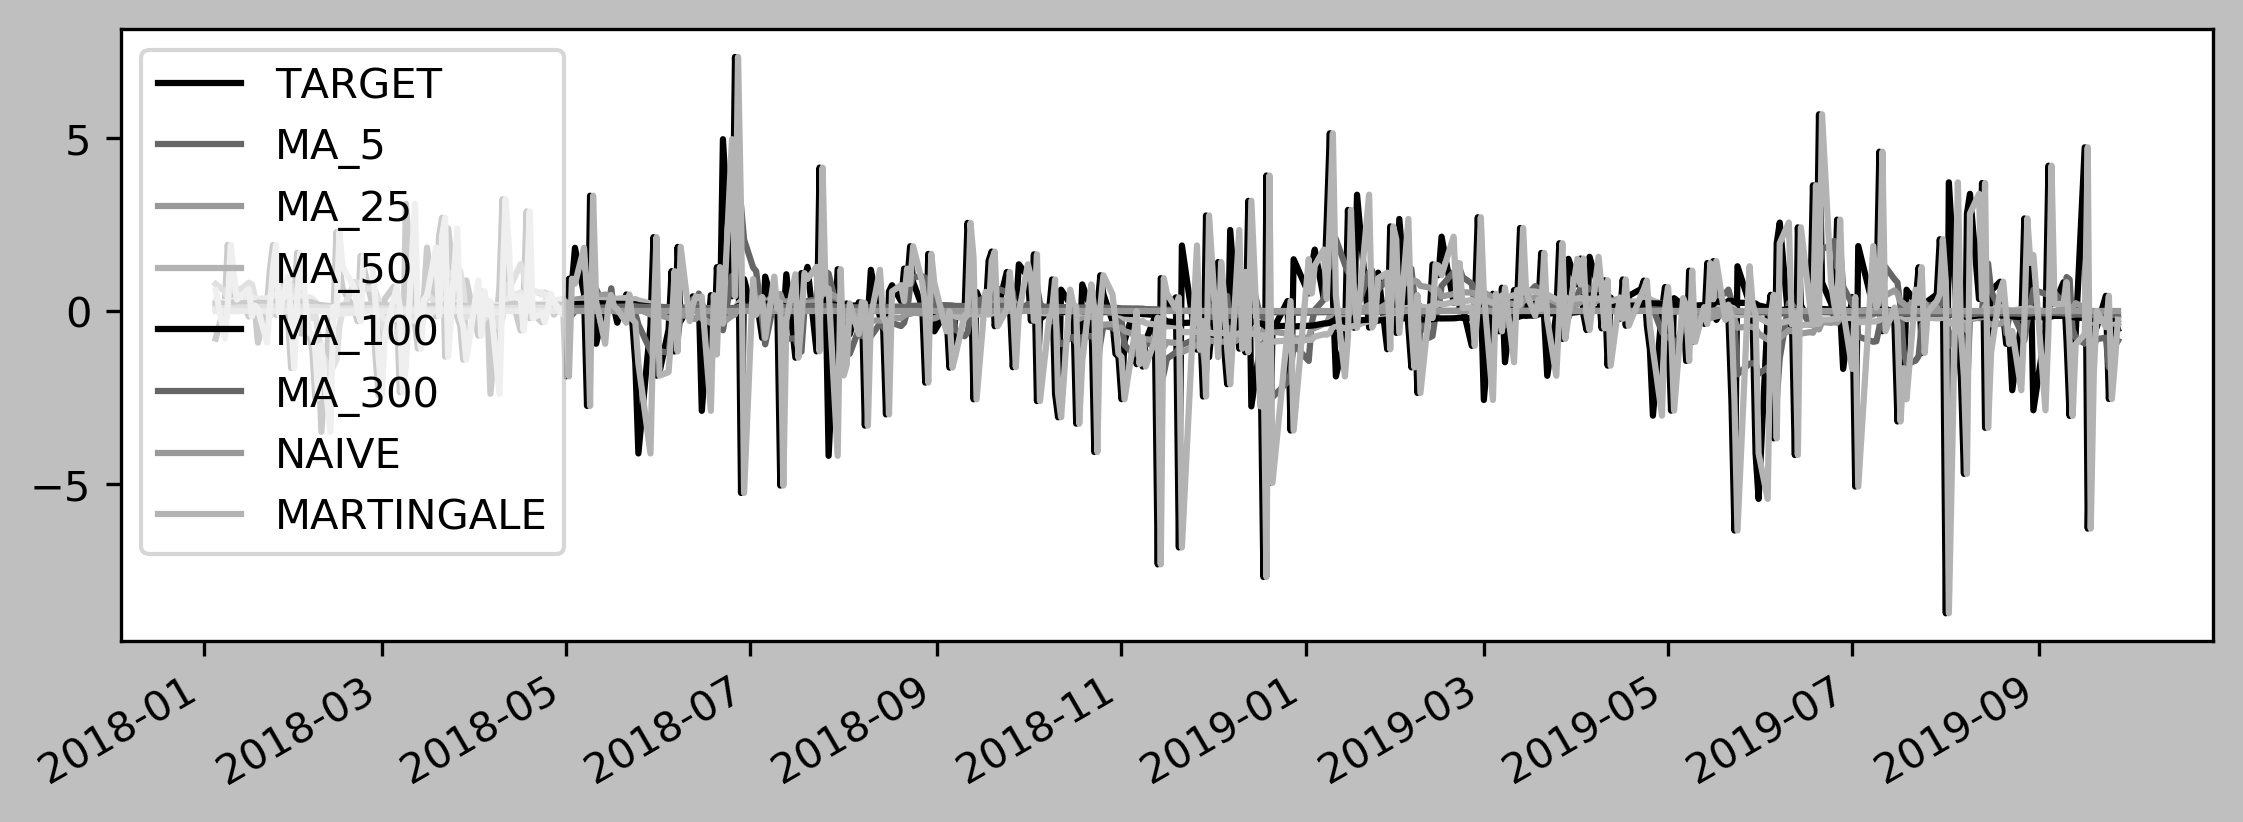

In [19]:
df_all.iloc[4500:,:].plot()
plt.show()

In [20]:
df_train = df_all[df_all.index < pd.to_datetime("2019-01-01")]
df_test = df_all[df_all.index >= pd.to_datetime("2019-01-01")]

In [21]:
def evaluate(df: pd.DataFrame, predictor: str) -> None:
    y_true = df["TARGET"]
    y_pred = df[predictor]
    print(f"========{predictor}========")
    print(f"MSE: {mse(y_true, y_pred):0.3f}")
    print(f"Directional Accuracy: {directional_accuracy(y_true, y_pred) * 100:0.3f}%")
    print(f"MAPE: {mape(y_true, y_pred):0.3f}")

## Performance on Training Set

In [22]:
predictor_lst = [c for c in df_all if c != "TARGET"]
for c in predictor_lst:
    evaluate(df_train, c)

========MA_5========
MSE: 5.612
Directional Accuracy: 50.274%
MAPE: 250.149
========MA_25========
MSE: 4.811
Directional Accuracy: 50.295%
MAPE: 151.393
========MA_50========
MSE: 4.725
Directional Accuracy: 49.536%
MAPE: 136.421
========MA_100========
MSE: 4.706
Directional Accuracy: 49.241%
MAPE: 118.541
========MA_300========
MSE: 4.676
Directional Accuracy: 47.977%
MAPE: 106.644
========NAIVE========
MSE: 4.655
Directional Accuracy: 0.716%
MAPE: 99.284
========MARTINGALE========
MSE: 9.684
Directional Accuracy: 48.146%
MAPE: 468.079


## Performance on Test Set

In [23]:
for c in predictor_lst:
    evaluate(df_test, c)

========MA_5========
MSE: 4.693
Directional Accuracy: 50.000%
MAPE: 260.123
========MA_25========
MSE: 4.248
Directional Accuracy: 50.000%
MAPE: 147.756
========MA_50========
MSE: 4.261
Directional Accuracy: 50.000%
MAPE: 130.194
========MA_100========
MSE: 4.226
Directional Accuracy: 44.624%
MAPE: 108.516
========MA_300========
MSE: 4.060
Directional Accuracy: 48.925%
MAPE: 100.472
========NAIVE========
MSE: 4.057
Directional Accuracy: 0.538%
MAPE: 99.462
========MARTINGALE========
MSE: 8.312
Directional Accuracy: 50.000%
MAPE: 442.451
